For each connecting rod appearing in the image, the vision system should provide the following
information:
1. Type of rod (A or B).
2. Position and orientation (modulo pi).
3. Length (L), Width (W), Width at the barycenter (WB).
4. For each hole, position of the centre and diameter size.

1. Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”).
2. Rods can have contact points but do not overlap one to another.
3. The inspection area may be dirty due to the presence of scattered iron powder.

In [70]:
import os
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import collections

file_list = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'Tesi33.bmp',
            'TESI44.BMP', 'TESI47.BMP', 'TESI48.BMP', 'TESI49.BMP', 'TESI50.BMP', 'TESI51.BMP',
            'TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']
m=0

In [134]:
path = os.path.join('/Users','corinnamarchili','Desktop','Progetto2','ispezione-bielle-immagini')
#img_file = file_list[m]
#m+=1
img_file = 'TESI98.BMP'
src = cv.imread(os.path.join(path, img_file), cv.COLOR_BGR2RGB)

Applying Gaussian smoothing to remove iron powder and imperfections, applying Otsu's thresholding method to binarize the image and make it independent of lighting conditions.

TESI98.BMP


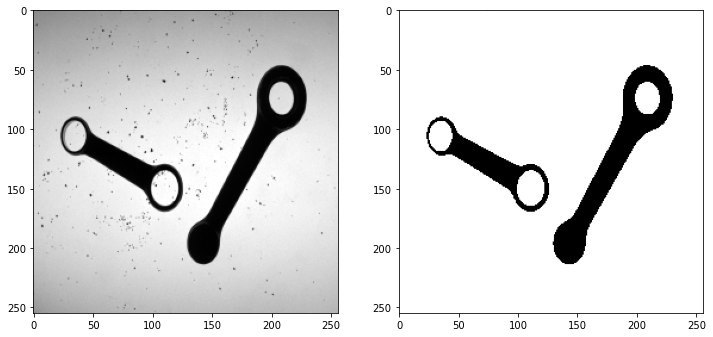

In [135]:
print(img_file)
#blur = cv.GaussianBlur(src,(5,5),0)
blur = cv.medianBlur(src,3)
_,dst = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(src, cmap='gray')
axarr[1].imshow(dst, cmap='gray')
plt.show()

Finding connected components:

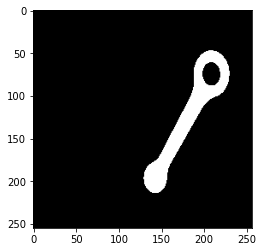

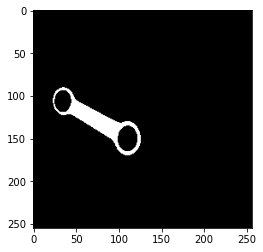

2


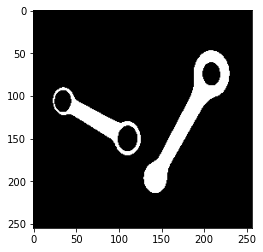

In [136]:
min_area = 1100
inverted = cv.bitwise_not(dst)
mask = np.zeros(inverted.shape, dtype="uint8")
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted, 8) 
component_masks={}
j=0
#create a black background image to store the results
img = np.zeros(inverted.shape, dtype="uint8")


blob_x = collections.defaultdict(list)
contact_points_img = 0

for i in range(1, num_labels):
    x = stats[i, cv.CC_STAT_LEFT]
    y = stats[i, cv.CC_STAT_TOP]
    w = stats[i, cv.CC_STAT_WIDTH]
    h = stats[i, cv.CC_STAT_HEIGHT]
    area = stats[i, cv.CC_STAT_AREA]
    if(area >= min_area):
        componentMask = (labels == i).astype("uint8") * 255
        component_masks[j] = componentMask
        # look for defects in the separation by using the convex hull 
        copy = component_masks[j].copy()
        contours, hierarchy = cv.findContours(image=copy, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
        cnt = contours[0]
        hull = cv.convexHull(cnt, returnPoints=False)
        defects = cv.convexityDefects(cnt, hull)
        
        # separate touching rods
        contact_points = []

        THRESH_POINTS = 4000
        for n in range(defects.shape[0]):
            s,e,f,d = defects[n,0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            if(d > THRESH_POINTS):
                contact_points.append(far)
        for c in range(len(contact_points)):
            if(c%2==0):
                cv.line(copy, contact_points[c], contact_points[c+1], (0, 0, 0), thickness=2, lineType=cv.LINE_AA)
        blob_x['components'].append(copy)
                
        contact_points_img = contact_points_img + len(contact_points)
        j+=1
    
filtered_blobs = collections.defaultdict(list)
for blob in blob_x['components']:
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(blob, 8)
    for i in range(1, num_labels):
        x = stats[i, cv.CC_STAT_LEFT]
        y = stats[i, cv.CC_STAT_TOP]
        w = stats[i, cv.CC_STAT_WIDTH]
        h = stats[i, cv.CC_STAT_HEIGHT]
        area = stats[i, cv.CC_STAT_AREA]
        if(area >= min_area):
            componentMask = (labels == i).astype("uint8") * 255
            filtered_blobs['components'].append(componentMask)
            plt.imshow(componentMask, cmap='gray')
            plt.show()
        
print(len(filtered_blobs['components']))
if(len(filtered_blobs['components']) > (len(blob_x['components']))):
    for i in range(len(filtered_blobs['components'])):
        img = img + filtered_blobs['components'][i]
        final_blobs = filtered_blobs
        print('here')
else:
    for i in range(len(blob_x['components'])):
        img = img + blob_x['components'][i]
        final_blobs = blob_x

plt.imshow(img, cmap='gray')
plt.show()

## Back here

Optional output vector (e.g. std::vector<cv::Vec4i>), containing information about the image topology. It has as many elements as the number of contours. For each i-th contour contours[i], the elements hierarchy[i][0] , hierarchy[i][1] , hierarchy[i][2] , and hierarchy[i][3] are set to 0-based indices in contours of the next and previous contours at the same hierarchical level, the first child contour and the parent contour, respectively. If for the contour i there are no next, previous, parent, or nested contours, the corresponding elements of hierarchy[i] will be negative. 

In [ ]:
import random

contours_voc = collections.defaultdict(list)
holes = {}
print(len(final_blobs['components']))
for index in range(0, len(final_blobs['components'])):
    blob = final_blobs['components'][index]
    count_holes = 0
    #src = cv.imread(os.path.join(path, img_file), cv.COLOR_BGR2RGB)
    src = blob
    #blur = cv.GaussianBlur(src,(5,5),0)
    #_,dst = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    inverted = src#cv.bitwise_not(dst)

    blob = inverted.copy()#component_masks[0]
    threshold=100
    #print(contact_points_img)
    if contact_points_img == 0:
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
        blob = cv.dilate(blob, kernel, iterations=1)      

    canny_output = cv.Canny(blob, threshold, threshold * 2)
    # Find contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw contours
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    print()
    for i in range(len(contours)):
        if(hierarchy[0][i][2] == -1 and hierarchy[0][i][3] != -1):
            print('found hole: ', hierarchy[0][i][2], hierarchy[0][i][3])
            count_holes += 1
            
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        cv.drawContours(drawing, contours, i, color, 1, cv.LINE_8, hierarchy, 0)
    holes[index] = count_holes


    contours, hierarchy = cv.findContours(image=img, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    for i in range(len(contours)):
        cnt = contours[i]
        rect = cv.minAreaRect(cnt)
        box = cv.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(drawing,[box],0,(255,255,255),1)
        contours_voc['rect'].append(rect)

    contours_voc['drawings'].append(drawing)
    if(holes[index] > 1):
        type_rod = 'B'
    else:
        type_rod = 'A'
        
    print(f'Blob {index} - type {type_rod}')
    
    
background = np.zeros((inverted.shape[0],inverted.shape[1], 3) , dtype="uint8")       
for element in contours_voc['drawings']:
    background = background + element
        
cv.imshow('Contours', background)
cv.waitKey()

2

found hole:  -1 2
Blob 0 - 1 holes, type A

found hole:  -1 2
found hole:  -1 4
Blob 1 - 2 holes, type B


In [319]:
((center_x,center_y), (width, height), angle) = rect

angle: 79.8


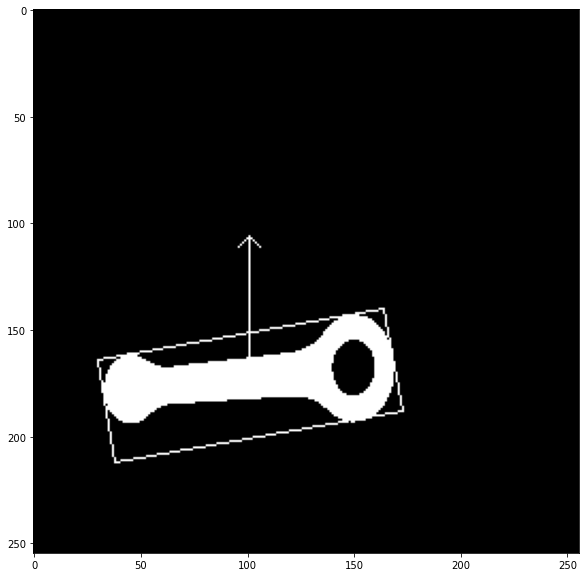

In [74]:
cv.arrowedLine(img, (int(center_x),int(center_y)), (int(center_x),int(center_y-70)), (255,0,0))
position = (200,200)
#cv.putText(img,f"angle: {angle:.1f}",position, cv.FONT_HERSHEY_PLAIN, color = (255, 255, 255), fontScale = 0.6)
print(f"angle: {angle:.1f}")
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

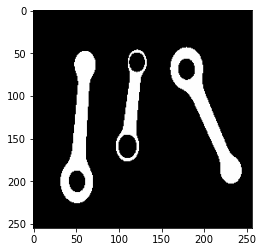

In [179]:
for i in range(0, connected_components_number):
    img = img + component_masks[i]
plt.imshow(img, cmap='gray')

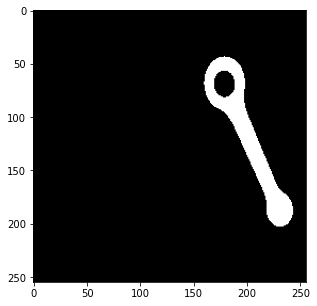

In [180]:
copy = component_masks[0].copy()
contours, hierarchy = cv.findContours(image=copy, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
sep = copy.copy()
cnt = contours[0]
hull = cv.convexHull(cnt, returnPoints=False)
defects = cv.convexityDefects(cnt, hull)


contact_points = []

THRESH_POINTS = 4000
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    if(d > THRESH_POINTS):
        contact_points.append(far)
        cv.circle(sep,far,1,[0,255,0])

for i in range(len(contact_points)):
    if(i%2==0):
        cv.line(sep, contact_points[i], contact_points[i+1], (0, 0, 0), thickness=3, lineType=cv.LINE_AA)
#cv.line(sep, contact_points[2], contact_points[3], (0, 0, 0), thickness=2, lineType=cv.LINE_AA)
plt.figure(figsize=(5, 5))
plt.imshow(sep, cmap='gray')

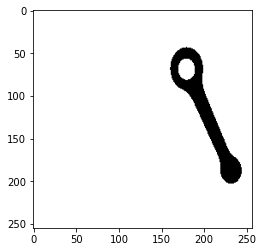

In [181]:
mask = np.zeros(sep.shape, dtype="uint8")

num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(sep, 8) 
component_masks={}
j=0
for i in range(1, num_labels):
    x = stats[i, cv.CC_STAT_LEFT]
    y = stats[i, cv.CC_STAT_TOP]
    w = stats[i, cv.CC_STAT_WIDTH]
    h = stats[i, cv.CC_STAT_HEIGHT]
    area = stats[i, cv.CC_STAT_AREA]
    if(area >= min_area):
        componentMask = (labels == i).astype("uint8") * 255
        component_masks[j] = componentMask
        j+=1
connected_components_number = len(component_masks.keys())
if(connected_components_number > 1):
    f, axarr = plt.subplots(1,connected_components_number, figsize=(12, 12))
    for i in range(0, connected_components_number):
        axarr[i].imshow(cv.bitwise_not(component_masks[i]), cmap='gray')
    plt.show()
else:
    plt.imshow(cv.bitwise_not(component_masks[0]), cmap='gray')

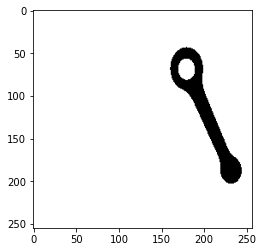

In [182]:
img = np.zeros(inverted.shape, dtype="uint8")
img.fill(255)
for i in range(0, connected_components_number):
    img = img + component_masks[i]
plt.imshow(img, cmap='gray')